# Model comparison

In this notebook we compare PEC corrections calculated with different ol-melt Fe-Mg Kd models

import the relevant packages

In [1]:
import MagmaPEC as mpc
import MagmaPandas as mp

import pandas as pd
import matplotlib.pyplot as plt
import geoplot as gp

# this is needed to clean up printed results during looped calculations
from IPython.display import clear_output

load data and set up FeOi according to the [FeOi](https://magmapec.readthedocs.io/en/latest/notebooks/FeOi.html) and [PEC correction](https://magmapec.readthedocs.io/en/latest/notebooks/pec_corr.html) examples.

In [2]:
melt_file = "./data/melt.csv"
olivine_file = "./data/olivine.csv"
pressure_file ="./data/pressure.csv"
wholerock_file = "./data/wholerock.csv"

melt = mp.read_melt(melt_file, index_col=["name"], units="wt. %")
olivine = mp.read_olivine(olivine_file, index_col=["name"], units="wt. %")
pressure = pd.read_csv(pressure_file, index_col = ["name"]).squeeze()
wholerock = mp.read_melt(wholerock_file, index_col=["name"])

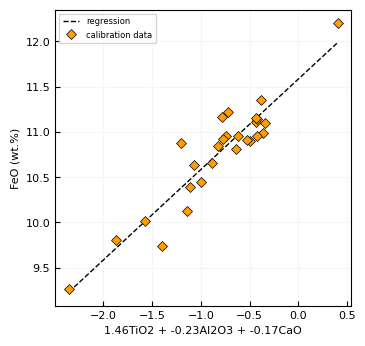

In [3]:
x = wholerock.drop(columns=["FeO"])
FeOi_predict = mpc.FeOi_prediction(x=x, FeO=wholerock["FeO"])

do_not_use = ["MnO", "P2O5", "Cr2O3", "total"]

model_fits = FeOi_predict.calculate_model_fits(exclude=do_not_use)
FeOi_predict.select_predictors(idx=3)
FeO_model = FeOi_predict.model

Here are all the Kd models we're going to test. You can also do this for Fe3Fe2 or melt thermometers instead with `mpc.Fe3Fe2_models` or `mpc.melt_thermometers`. 

In [4]:
Kd_models = mpc.Kd_ol_FeMg_models
Kd_models

['blundy2020',
 'fixed',
 'putirka2016_8a',
 'putirka2016_8b',
 'putirka2016_8c',
 'putirka2016_8d',
 'saper2022',
 'sun2020',
 'toplis2005']

Now we calculate PEC corrections iteratively for each Kd model. 

For a fixed Kd we also need to define the value and its error and pass them as a list to the configuration

Crystallization extents are stored in the `pec_results` dataframe and corrected melt compositions in the `corrected_inclusions` dictionary. This dictionary uses Kd model names as keys and stores compositions in dataframes.

In [5]:
pec_results = pd.DataFrame(index=melt.index, dtype=float)
corrected_inclusions = {}

Kd_value = 0.35
Kd_error = 0.02

for i, model in enumerate(Kd_models):

    # add Kd value and error if the model is 'fixed'
    set_model = model if model != "fixed" else (model, Kd_value, Kd_error)
    # set the Kd model
    mpc.model_configuration.Kd_model = set_model

    clear_output()
    print(f"model: {model}\n{i+1:03}/{len(Kd_models):03}")

    pec_model = mpc.PEC(inclusions=melt, olivines=olivine, P_bar=pressure, FeO_target=FeO_model)
    melts_corrected, pec, checks = pec_model.correct()

    pec_results[set_model] = pec["total_crystallisation"]
    corrected_inclusions[set_model] = melts_corrected.copy()
    

model: toplis2005
009/009
Equilibrating ... |██████████████████████████████| 100% [10/10] in 3.4s 
Correcting    ... |██████████████████████████████| 100% [10/10] in 14.0s 


These are the crystallization extents calculated with the different models

In [6]:
pec_results

,blundy2020,"(fixed, 0.35, 0.02)",putirka2016_8a,putirka2016_8b,putirka2016_8c,putirka2016_8d,saper2022,sun2020,toplis2005
name,,,,,,,,,
PI032-04-01,9.669983,12.221924,10.917725,10.917725,10.910095,10.841650,6.590302,12.917725,9.796851
PI032-04-02,10.807312,13.931787,12.135925,12.056689,12.250586,12.050586,7.784198,14.326660,10.807312
PI041-02-02,1.159460,2.836523,1.929163,1.754883,1.927637,1.756409,-1.006763,2.918481,-0.005502
PI041-03-01,14.807861,17.614844,16.084595,15.304321,15.492114,14.007861,11.345508,19.764160,12.645239
PI041-03-03,14.341699,17.221924,15.762085,14.461047,15.250366,13.350854,11.000000,19.539307,12.131775
PI041-05-04,-2.556934,-0.966846,-1.805542,-2.505273,-2.147778,-2.496118,-4.984302,-1.109082,-4.403699
PI041-05-06,3.488623,5.703125,4.443066,3.703882,4.091675,3.344861,0.800000,5.579199,1.994775
PI041-07-01,13.533203,16.312500,14.638818,13.720996,14.251025,12.945410,9.790521,17.044922,12.212329
PI041-07-02,12.960449,15.674243,14.072168,13.151294,13.681323,12.419739,9.193353,17.053857,11.118481


And here are two examples of the associated corrected melt compositions

In [7]:
corrected_inclusions["blundy2020"]

,SiO2,Al2O3,MgO,CaO,FeO,Na2O,K2O,MnO,TiO2,P2O5,Cr2O3,CO2,H2O,F,S,Cl,total
name,,,,,,,,,,,,,,,,,
PI032-04-01,48.943719,14.013614,7.630094,9.705938,10.314919,3.602243,0.672540,0.138315,2.456433,0.279344,0.000000,0.605778,1.388135,0.076006,0.140193,0.032730,100.0
PI032-04-02,48.479654,14.629497,7.547376,9.386726,10.340466,3.449630,0.910037,0.140879,2.567158,0.325500,0.000000,0.650701,1.288021,0.081179,0.160070,0.043106,100.0
PI041-02-02,49.035956,16.830785,5.174158,9.123172,10.257030,3.761868,1.070182,0.157860,2.784544,0.557070,0.000000,0.460645,0.650866,0.047317,0.067540,0.021008,100.0
PI041-03-01,45.805062,15.410386,7.866142,10.765738,10.734843,3.273348,1.119837,0.117426,3.084403,0.539931,0.000000,0.780285,0.286932,0.077762,0.084965,0.052940,100.0
PI041-03-03,45.225725,15.624567,7.725401,10.983367,10.806821,3.356069,1.146547,0.094428,3.203774,0.508575,0.000000,0.806345,0.305534,0.080243,0.078065,0.054541,100.0
PI041-05-04,47.739154,18.499127,4.168579,9.356278,9.387706,4.577251,1.598948,0.142979,2.474740,0.821254,0.000000,0.507617,0.459434,0.087337,0.120858,0.058737,100.0
PI041-05-06,46.350575,16.864911,5.158561,8.871758,11.454093,3.976689,1.407932,0.173516,3.611212,0.615599,0.000000,0.636053,0.582065,0.106742,0.127315,0.062978,100.0
PI041-07-01,45.738018,15.077100,7.642742,9.589114,11.633964,3.098567,1.259341,0.150583,3.496301,0.549176,0.000000,0.462927,1.010345,0.074330,0.161746,0.055747,100.0
PI041-07-02,45.806314,15.375532,7.401513,9.952743,11.490914,3.149061,1.342889,0.139523,3.489543,0.608231,0.000000,0.367453,0.608398,0.072640,0.138611,0.056636,100.0


In [8]:
corrected_inclusions["saper2022"]

,SiO2,Al2O3,MgO,CaO,FeO,Na2O,K2O,MnO,TiO2,P2O5,Cr2O3,CO2,H2O,F,S,Cl,total
name,,,,,,,,,,,,,,,,,
PI032-04-01,49.206233,14.365838,6.636341,9.940199,10.233057,3.692838,0.689454,0.132211,2.518211,0.286370,0.000000,0.621013,1.423046,0.077918,0.143719,0.033553,100.0
PI032-04-02,48.691045,14.986061,6.571461,9.606162,10.303377,3.533640,0.932200,0.135733,2.629678,0.333427,0.000000,0.666547,1.319389,0.083156,0.163968,0.044156,100.0
PI041-02-02,49.228087,17.112982,4.413466,9.268368,10.248313,3.825082,1.088165,0.149435,2.831335,0.566431,0.000000,0.468385,0.661803,0.048112,0.068675,0.021361,100.0
PI041-03-01,45.991137,15.828645,6.792065,11.047336,10.675971,3.362487,1.150332,0.111175,3.168397,0.554635,0.000000,0.801534,0.294746,0.079879,0.087279,0.054382,100.0
PI041-03-03,45.388617,16.031367,6.639883,11.258630,10.804800,3.443792,1.176516,0.087660,3.287515,0.521868,0.000000,0.827421,0.313520,0.082340,0.080105,0.055966,100.0
PI041-05-04,47.880455,18.844295,3.375884,9.522744,9.336220,4.662865,1.628855,0.133975,2.521028,0.836615,0.000000,0.517112,0.468028,0.088971,0.123118,0.059836,100.0
PI041-05-06,46.481016,17.212464,4.258297,9.046185,11.480980,4.059090,1.437106,0.163918,3.686041,0.628355,0.000000,0.649232,0.594126,0.108954,0.129953,0.064283,100.0
PI041-07-01,45.867609,15.532570,6.515228,9.866277,11.598683,3.192366,1.297463,0.143335,3.602140,0.565800,0.000000,0.476941,1.040930,0.076580,0.166642,0.057435,100.0
PI041-07-02,45.927100,15.826762,6.307860,10.232779,11.449861,3.241603,1.382352,0.133202,3.592089,0.626105,0.000000,0.378252,0.626277,0.074774,0.142684,0.058300,100.0


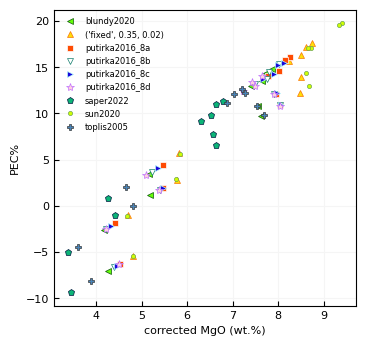

In [11]:
mm = 1/25.4
gp.layout(colors=gp.colors.bright)

fig, ax = plt.subplots(figsize=(90*mm, 85*mm))

for model, df in corrected_inclusions.items():

    ax.plot(df["MgO"], pec_results[model], lw=0., label=model)


ax.legend()
ax.set_xlabel("corrected MgO (wt.%)")
ax.set_ylabel("PEC%")

plt.show()